In [1]:
import torch
import numpy as np
import os
import gpt as g
import matplotlib.pyplot as plt

import sys
sys.path.append("src/")
from qcd_ml.dirac import dirac_wilson_clover
from qcd_ml.nn.lptc import v_LPTC_NG

SharedMemoryMpi:  World communicator of size 1
SharedMemoryMpi:  Node  communicator of size 1
SharedMemoryMpi: SharedMemoryAllocate 1073741824 MMAP anonymous implementation 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the terms of the 

In [2]:
def lattice2ndarray(lattice):
    """ 
    Converts a gpt (https://github.com/lehner/gpt) lattice to a numpy ndarray 
    keeping the ordering of axes as one would expect.
    Example::
        q_top = g.qcd.gauge.topological_charge_5LI(U_smeared, field=True)
        plot_scalar_field(lattice2ndarray(q_top))
    """
    shape = lattice.grid.fdimensions
    shape = list(reversed(shape))
    if lattice[:].shape[1:] != (1,):
        shape.extend(lattice[:].shape[1:])
   
    result = lattice[:].reshape(shape)
    result = np.swapaxes(result, 0, 3)
    result = np.swapaxes(result, 1, 2)
    return result

def ndarray2lattice(ndarray, grid, lat_constructor):
    """
    Converts an ndarray to a gpt lattice, it is the inverse 
    of lattice2ndarray.

    Example::
        lat = ndarray2lattice(arr, g.grid([4,4,4,8], g.double), g.vspincolor)
    """
    lat = lat_constructor(grid)
    data = np.swapaxes(ndarray, 0, 3)
    data = np.swapaxes(data, 1, 2)
    lat[:] = data.reshape([data.shape[0] * data.shape[1] * data.shape[2] * data.shape[3]] + list(data.shape[4:]))
    return lat

In [3]:
grid = g.grid([4, 4, 4, 8], g.double)

rng = g.random("foo")
psi = g.vspincolor(grid)

rng.cnormal(psi)

ndarray1 = lattice2ndarray(psi)
ndarray2 = lattice2ndarray(ndarray2lattice(ndarray1, grid, g.vspincolor))

assert np.allclose(ndarray1, ndarray2)

GPT :       3.031011 s : Initializing gpt.random(foo,vectorized_ranlux24_389_64) took 0.000816107 s


In [4]:
def GMRES_torch(A, b, x0, maxiter=1000, eps=1e-4
              , regulate_b_norm=1e-4
              , innerproduct=None
              , prec=None):
    """
    GMRES solver.
    
    innerproduct is a function (vec,vec)->scalar which is a product.
    prec is a function vec->vec.

    Literature:
    - https://en.wikipedia.org/wiki/Generalized_minimal_residual_method
    - https://www-users.cse.umn.edu/~saad/Calais/PREC.pdf

    Authors:
    - Daniel Knüttel 2024
    """
    if hasattr(A, "__call__"):
        apply_A = lambda x: A(x)
    else:
        apply_A = lambda x: A @ x

    if innerproduct is None:
        innerproduct = lambda x,y: (x.conj() * y).sum()

    
    rk = b - apply_A(x0)

    b_norm = np.sqrt(innerproduct(b, b).real) + regulate_b_norm
    
    rk_norm = np.sqrt(innerproduct(rk, rk).real)
    res = rk_norm / b_norm
    if rk_norm / b_norm <= eps:
        return x0, {"converged": True, "k": 0}

    vk = rk / rk_norm

    v = [None, vk]
    
    cs = np.zeros(maxiter + 2, np.complex128)
    sn = np.zeros(maxiter + 2, np.complex128)
    gamma = np.zeros(maxiter + 2, np.complex128)
    gamma[1] = rk_norm
    H = [None]
    
    converged = False
    for k in range(1, maxiter + 1):
        if prec is not None:
            z = prec(v[k])
        else:
            z = v[k]
        qk = apply_A(z)
        
        Hk = np.zeros(k + 2, np.complex128)
        for i in range(1, k + 1):
            Hk[i] = innerproduct(v[i], qk)
        for i in range(1, k + 1):
            qk -= Hk[i] * v[i]
            
        Hk[k+1] = np.sqrt(innerproduct(qk, qk).real)
        v.append(qk / Hk[k+1])

        for i in range(1, k):
            # (c   s ) [a]   [a']
            # (-s* c*) [b] = [b']
            tmp = cs[i+1] * Hk[i] + sn[i+1] * Hk[i+1]
            Hk[i+1] = -np.conj(sn[i+1]) * Hk[i] + np.conj(cs[i+1]) * Hk[i+1]
            Hk[i] = tmp
            

        beta = np.sqrt(np.abs(Hk[k])**2 + np.abs(Hk[k + 1])**2)

        # ( c    s )[a]   [X]
        # (-s*   c*)[b] = [0]
        # is solved by 
        # s* = b; c* = a
        sn[k+1] = np.conj(Hk[k+1]) / beta
        cs[k+1] = np.conj(Hk[k]) / beta
        Hk[k] = cs[k+1] * Hk[k] + sn[k+1] * Hk[k+1]
        Hk[k+1] = 0
        
        
        gamma[k+1] = -np.conj(sn[k+1]) * gamma[k]
        gamma[k] = cs[k+1] * gamma[k]
        
        H.append(Hk)
        res = np.abs(gamma[k+1]) / b_norm

        if np.abs(gamma[k+1]) / b_norm <= eps:
            converged = True
            break

    y = np.zeros(k+1, np.complex128)
    for i in reversed(range(1, k + 1)):
        overlap = 0
        for j in range(i+1, k+1):
            overlap += H[j][i] * y[j]
        y[i] = (gamma[i] - overlap) / H[i][i]
    if prec is None:
        x = x0 + sum(yi * vi for yi, vi in zip(y[1:], v[1:]))
    else:
        x = x0 + sum(yi * prec(vi) for yi, vi in zip(y[1:], v[1:]))
    return x, {"converged": converged, "k": k, "res": res}

In [5]:
innerproduct = lambda x,y: (x.conj() * y).sum()
norm = lambda x: torch.sqrt(innerproduct(x, x).real)

def orthonormalize(vecs):
    basis = []
    for vec in vecs:
        for b in basis:
            vec = vec - innerproduct(b, vec) * b
        vec = vec / norm(vec)
        basis.append(vec)
    return basis

In [6]:
psi = torch.complex(
        torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double)
        , torch.randn(8, 8, 8, 16, 4, 3, dtype=torch.double))

n_basis = 4

bv = [torch.randn_like(psi) for _ in range(n_basis)]
#bv = orthonormalize(bv)
bv = [bi / norm(bi) for bi in bv]

In [7]:
for b1 in bv:
    for b2 in bv:
        print(f"{innerproduct(b1, b2): .1e}  ", end="")
    print()

 1.0e+00+0.0e+00j   1.8e-03-2.0e-04j  -6.2e-05-5.7e-04j  -1.3e-03-3.5e-04j  
 1.8e-03+2.0e-04j   1.0e+00+0.0e+00j  -9.6e-04-4.1e-04j  -5.2e-04+1.3e-03j  
-6.2e-05+5.7e-04j  -9.6e-04+4.1e-04j   1.0e+00+0.0e+00j  -2.3e-04+2.8e-03j  
-1.3e-03+3.5e-04j  -5.2e-04-1.3e-03j  -2.3e-04-2.8e-03j   1.0e+00+0.0e+00j  


In [8]:

U = torch.tensor(np.load(os.path.join("test", "assets","1500.config.npy")))
U_gpt = g.load("/home/knd35666/data/ensembles/ens_001/1500.config/")
w_gpt = g.qcd.fermion.wilson_clover(U_gpt, {"mass": -0.55,
    "csw_r": 0.0,
    "csw_t": 0.0,
    "xi_0": 1.0,
    "nu": 1.0,
    "isAnisotropic": False,
    "boundary_phases": [1,1,1,1]})

#w_torch = dirac_wilson_clover(U, -0.5, 1.0)
w = lambda x: torch.tensor(lattice2ndarray(w_gpt(ndarray2lattice(x.numpy(), U_gpt[0].grid, g.vspincolor))))


GPT :       4.728721 s : Reading /home/knd35666/data/ensembles/ens_001/1500.config/
GPT :       4.742250 s : Switching view to [1,1,1,1]/Read
GPT :       5.071882 s : Read 0.00109863 GB at 0.0033328 GB/s (0.00385848 GB/s for distribution, 0.024466 GB/s for reading + checksum, 0.0817239 GB/s for checksum, 1 views per node)
GPT :       5.112854 s : Read 0.00109863 GB at 0.0293102 GB/s (0.0568124 GB/s for distribution, 0.0605607 GB/s for reading + checksum, 0.487619 GB/s for checksum, 1 views per node)
GPT :       5.145849 s : Read 0.00109863 GB at 0.0339463 GB/s (0.06537 GB/s for distribution, 0.0706326 GB/s for reading + checksum, 0.320222 GB/s for checksum, 1 views per node)
GPT :       5.180851 s : Read 0.00109863 GB at 0.0319352 GB/s (0.0616991 GB/s for distribution, 0.0662145 GB/s for reading + checksum, 0.226315 GB/s for checksum, 1 views per node)
GPT :       5.181491 s : Completed reading /home/knd35666/data/ensembles/ens_001/1500.config/ in 0.456621 s


In [9]:
import time

start = time.perf_counter_ns()
w(psi)
stop = time.perf_counter_ns()
print((stop - start) / 1000 / 1000)

1116.145477


In [10]:
def GMRES_restarted(A, b, x0, max_restart=10, maxiter_inner=100, eps=1e-4
              , regulate_b_norm=1e-3
              , innerproduct=None
              , prec=None):
    x = x0
    total_iterations = 0
    for rs in range(max_restart):
        x, ret = GMRES_torch(A, b, x, maxiter=maxiter_inner, eps=1e-4
              , regulate_b_norm=regulate_b_norm
              , innerproduct=None
              , prec=None)
        total_iterations += ret["k"]
        print("restarting with res:", ret["res"])
        if ret["converged"]:
            break
    ret["k"] = total_iterations
    return x, ret

In [11]:
zero = torch.zeros_like(psi)

ui = []
for i, b in enumerate(bv):
    uk, ret = GMRES_restarted(w, zero, b, eps=1e-3, maxiter_inner=20, max_restart=4)
    print(f"[{i:2d}]: {ret['converged']} ({ret['k']:5d})")
    ui.append(uk)


restarting with res: tensor(5.4431, dtype=torch.float64)
restarting with res: tensor(0.3315, dtype=torch.float64)
restarting with res: tensor(0.0304, dtype=torch.float64)
restarting with res: tensor(0.0029, dtype=torch.float64)
[ 0]: False (   80)
restarting with res: tensor(5.5321, dtype=torch.float64)
restarting with res: tensor(0.3283, dtype=torch.float64)
restarting with res: tensor(0.0306, dtype=torch.float64)
restarting with res: tensor(0.0030, dtype=torch.float64)
[ 1]: False (   80)
restarting with res: tensor(5.5858, dtype=torch.float64)
restarting with res: tensor(0.3317, dtype=torch.float64)
restarting with res: tensor(0.0296, dtype=torch.float64)
restarting with res: tensor(0.0029, dtype=torch.float64)
[ 2]: False (   80)
restarting with res: tensor(5.6054, dtype=torch.float64)
restarting with res: tensor(0.3395, dtype=torch.float64)
restarting with res: tensor(0.0331, dtype=torch.float64)
restarting with res: tensor(0.0032, dtype=torch.float64)
[ 3]: False (   80)


In [12]:
for b1 in ui:
    for b2 in ui:
        print(f"{abs(innerproduct(b1, b2)): .1e}  ", end="")
    print()

 6.2e-11   4.5e-12   1.6e-11   4.6e-11  
 4.5e-12   7.3e-11   3.9e-11   1.7e-11  
 1.6e-11   3.9e-11   6.4e-11   1.4e-11  
 4.6e-11   1.7e-11   1.4e-11   8.4e-11  


In [13]:
block_size = [4, 4, 4, 4]

In [14]:
uk.shape

torch.Size([8, 8, 8, 16, 4, 3])

In [15]:
L_fine = uk.shape[:4]
L_fine

torch.Size([8, 8, 8, 16])

In [16]:
L_coarse = [lf // bs for lf, bs in zip(L_fine, block_size)]

In [17]:
L_coarse

[2, 2, 2, 4]

In [18]:
import itertools
from collections import deque

# 

In [19]:
lx, ly, lz, lt = block_size

ui_blocked = list(np.empty(L_coarse, dtype=object))

for bx, by, bz, bt in itertools.product(*(range(li) for li in L_coarse)):
    for uk in ui:
        u_block = uk[bx * lx: (bx + 1)*lx
                    , by * ly: (by + 1)*ly
                    , bz * lz: (bz + 1)*lz
                    , bt * lt: (bt + 1)*lt]
        if ui_blocked[bx][by][bz][bt] is None:
            ui_blocked[bx][by][bz][bt]  = []
        ui_blocked[bx][by][bz][bt].append(u_block)
    
    ui_blocked[bx][by][bz][bt] = orthonormalize(ui_blocked[bx][by][bz][bt])

In [20]:
len(ui_blocked[0][0][0][0])


4

In [21]:
def v_project(block_size, ui_blocked, n_basis, L_coarse, v):
    projected = torch.complex(torch.zeros(L_coarse + [n_basis], dtype=torch.double)
                              , torch.zeros(L_coarse + [n_basis], dtype=torch.double))
    lx, ly, lz, lt = block_size
    
    for bx, by, bz, bt in itertools.product(*(range(li) for li in L_coarse)):
        for k, uk in enumerate(ui_blocked[bx][by][bz][bt]):
            projected[bx, by, bz, bt, k] = innerproduct(v[bx * lx: (bx + 1)*lx
                                                        , by * ly: (by + 1)*ly
                                                        , bz * lz: (bz + 1)*lz
                                                        , bt * lt: (bt + 1)*lt], uk)
    return projected

In [22]:
def v_prolong(block_size, ui_blocked, n_basis, L_coarse, v):
    L_fine = [bi*li for bi,li in zip(block_size, L_coarse)]
    prolonged = torch.complex(torch.zeros(L_fine + list(ui_blocked[0][0][0][0][0].shape[4:]), dtype=torch.double)
                              , torch.zeros(L_fine + list(ui_blocked[0][0][0][0][0].shape[4:]), dtype=torch.double))
    for bx, by, bz, bt in itertools.product(*(range(li) for li in L_coarse)):
        for k, uk in enumerate(ui_blocked[bx][by][bz][bt]):
            prolonged[bx * lx: (bx + 1)*lx
                    , by * ly: (by + 1)*ly
                    , bz * lz: (bz + 1)*lz
                    , bt * lt: (bt + 1)*lt] += v[bx,by,bz,bt,k] * uk
    return prolonged

In [23]:
v_prolong(block_size, ui_blocked, n_basis, L_coarse, v_project(block_size, ui_blocked, n_basis, L_coarse, psi))

tensor([[[[[[ 1.8601e-02+6.1073e-03j,  1.9228e-02-2.4832e-03j,
              5.3345e-03+7.9957e-03j],
            [ 4.2728e-02-1.0775e-02j, -1.1632e-03+1.2310e-02j,
              5.0037e-03+9.2096e-03j],
            [ 2.4580e-02+1.0794e-02j, -3.0413e-02+2.2369e-02j,
              2.3203e-02-1.2279e-02j],
            [-4.0920e-02+1.1129e-02j, -3.5163e-02-2.1063e-02j,
              2.1635e-02-1.6982e-02j]],

           [[ 1.6132e-02-1.5805e-02j, -2.8457e-02-2.2068e-02j,
             -7.7127e-03-1.2085e-02j],
            [-1.8942e-02-3.3937e-02j, -2.7723e-03+1.9706e-02j,
             -2.2896e-03-3.0149e-03j],
            [ 2.8574e-03-2.3807e-02j,  5.2732e-02+6.5714e-03j,
             -7.8919e-03-2.5852e-02j],
            [ 4.1051e-02+2.9798e-02j,  1.9179e-02+4.6874e-03j,
             -2.4889e-02+2.4146e-02j]],

           [[ 5.1717e-03-4.2900e-03j, -1.4040e-02+5.2648e-02j,
              3.4864e-04-1.8872e-02j],
            [-1.6247e-02-6.1342e-03j,  1.6406e-02+1.2984e-02j,
             -2

In [24]:
for bx, by, bz, bt in itertools.product(*(range(li) for li in L_coarse)):
    for k, uk in enumerate(ui_blocked[bx][by][bz][bt]):
        projected = torch.complex(torch.zeros(L_coarse + [n_basis], dtype=torch.double)
                          , torch.zeros(L_coarse + [n_basis], dtype=torch.double))
        projected[bx,by,bz,bt,k] = 1
        print(bx, by, bz, bt, k)
        assert torch.allclose(projected
                              , v_project(block_size, ui_blocked, n_basis, L_coarse, v_prolong(block_size, ui_blocked, n_basis, L_coarse, projected))
                             )

0 0 0 0 0
0 0 0 0 1
0 0 0 0 2
0 0 0 0 3
0 0 0 1 0
0 0 0 1 1
0 0 0 1 2
0 0 0 1 3
0 0 0 2 0
0 0 0 2 1
0 0 0 2 2
0 0 0 2 3
0 0 0 3 0
0 0 0 3 1
0 0 0 3 2
0 0 0 3 3
0 0 1 0 0
0 0 1 0 1
0 0 1 0 2
0 0 1 0 3
0 0 1 1 0
0 0 1 1 1
0 0 1 1 2
0 0 1 1 3
0 0 1 2 0
0 0 1 2 1
0 0 1 2 2
0 0 1 2 3
0 0 1 3 0
0 0 1 3 1
0 0 1 3 2
0 0 1 3 3
0 1 0 0 0
0 1 0 0 1
0 1 0 0 2
0 1 0 0 3
0 1 0 1 0
0 1 0 1 1
0 1 0 1 2
0 1 0 1 3
0 1 0 2 0
0 1 0 2 1
0 1 0 2 2
0 1 0 2 3
0 1 0 3 0
0 1 0 3 1
0 1 0 3 2
0 1 0 3 3
0 1 1 0 0
0 1 1 0 1
0 1 1 0 2
0 1 1 0 3
0 1 1 1 0
0 1 1 1 1
0 1 1 1 2
0 1 1 1 3
0 1 1 2 0
0 1 1 2 1
0 1 1 2 2
0 1 1 2 3
0 1 1 3 0
0 1 1 3 1
0 1 1 3 2
0 1 1 3 3
1 0 0 0 0
1 0 0 0 1
1 0 0 0 2
1 0 0 0 3
1 0 0 1 0
1 0 0 1 1
1 0 0 1 2
1 0 0 1 3
1 0 0 2 0
1 0 0 2 1
1 0 0 2 2
1 0 0 2 3
1 0 0 3 0
1 0 0 3 1
1 0 0 3 2
1 0 0 3 3
1 0 1 0 0
1 0 1 0 1
1 0 1 0 2
1 0 1 0 3
1 0 1 1 0
1 0 1 1 1
1 0 1 1 2
1 0 1 1 3
1 0 1 2 0
1 0 1 2 1
1 0 1 2 2
1 0 1 2 3
1 0 1 3 0
1 0 1 3 1
1 0 1 3 2
1 0 1 3 3
1 1 0 0 0
1 1 0 0 1
1 1 0 0 2
1 1 0 0 3


In [25]:
def get_coarse_operator(block_size, ui_blocked, n_basis, L_coarse, fine_operator):
    def operator(source_coarse):
        source_fine = v_prolong(block_size, ui_blocked, n_basis, L_coarse, source_coarse)
        dst_fine = fine_operator(source_fine)
        return v_project(block_size, ui_blocked, n_basis, L_coarse, dst_fine)
    return operator

In [26]:
w_coarse = get_coarse_operator(block_size, ui_blocked, n_basis, L_coarse, w)

In [27]:
psi_coarse = v_project(block_size, ui_blocked, n_basis, L_coarse, psi)

In [28]:
psi_coarse.shape

torch.Size([2, 2, 2, 4, 4])

In [29]:

def complex_mse_loss(output, target):
    err = (output - target)
    return (err * err.conj()).real.sum()


def l2norm(v):
    return (v * v.conj()).real.sum()

In [30]:
paths = [[]] + [[(mu, 1)] for mu in range(4)] + [[(3, -1)]]

layer = v_LPTC_NG(1, 1, paths, psi_coarse.shape[:-1], 4)
#layer.weights.data[:,:,:] = zeros
#layer.weights.data[:,:,0] = idty

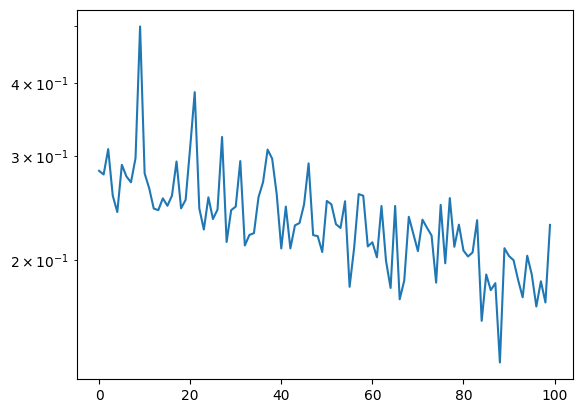

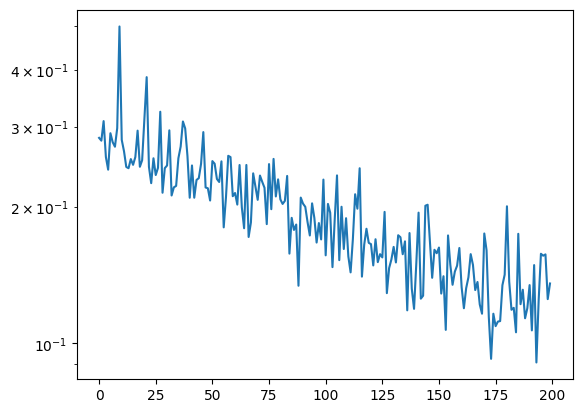

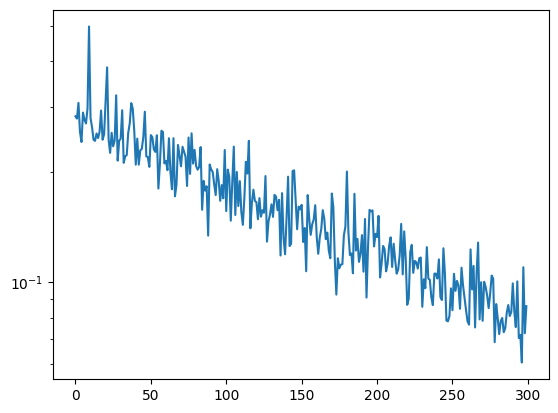

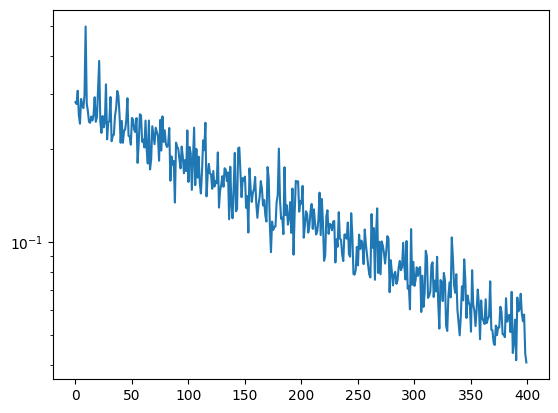

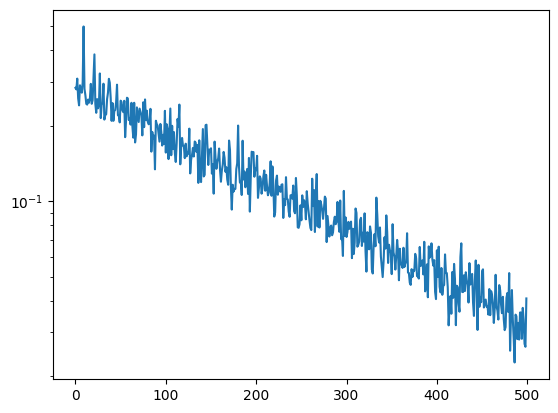

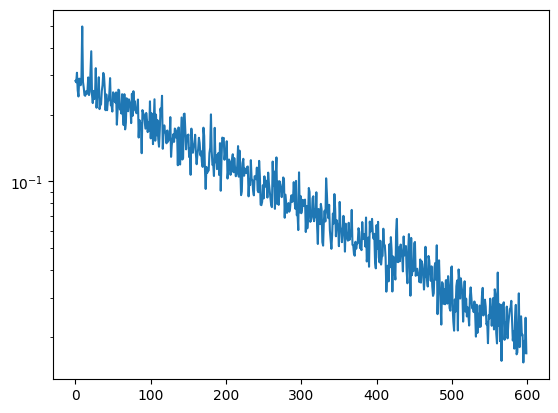

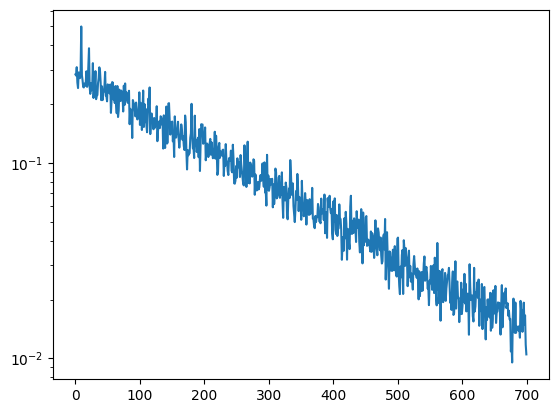

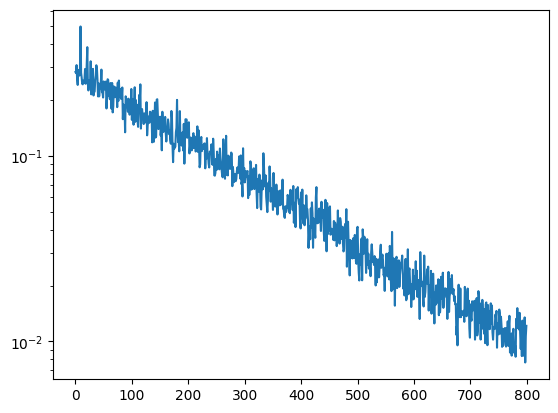

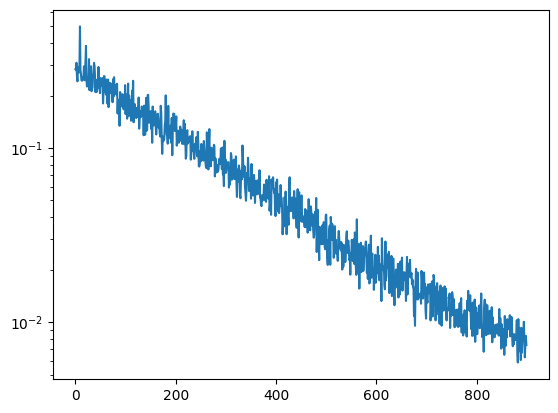

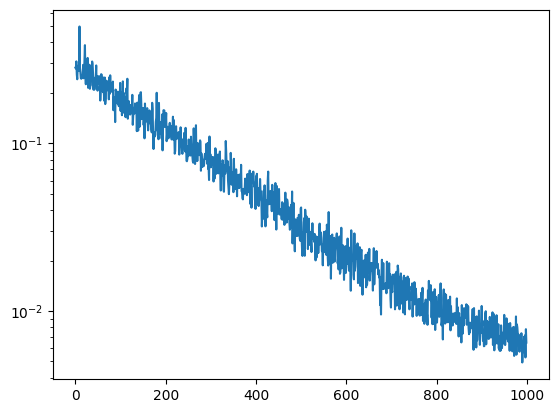

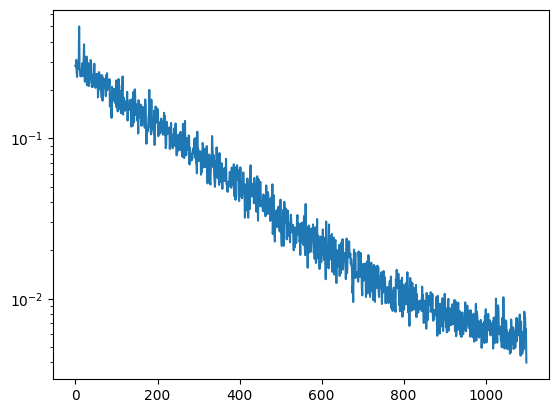

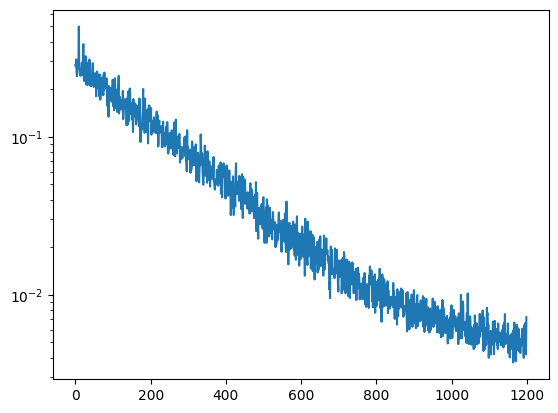

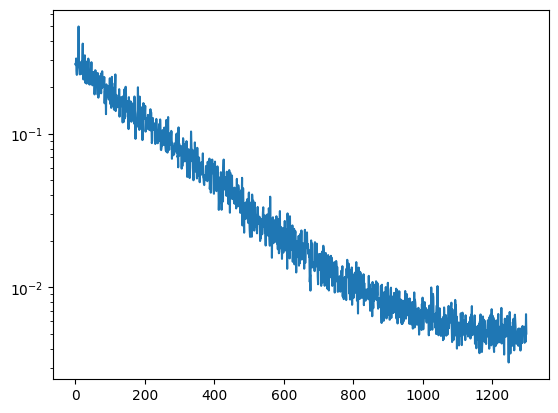

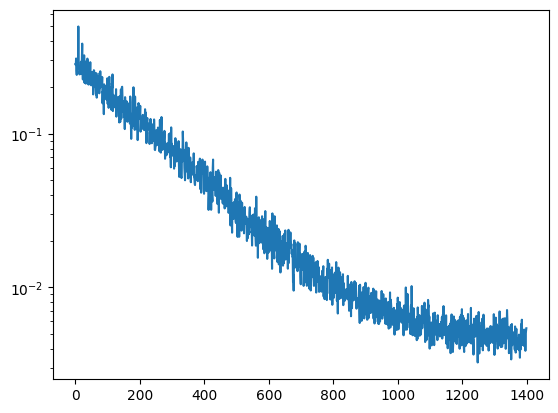

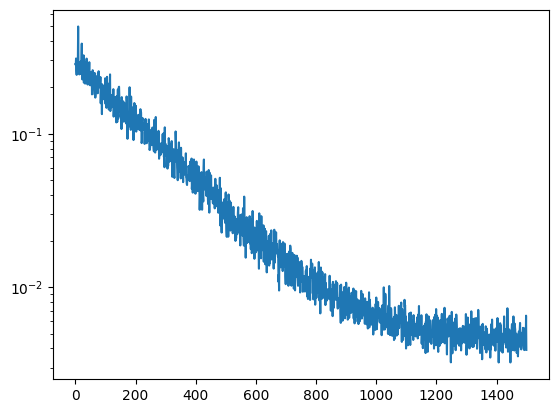

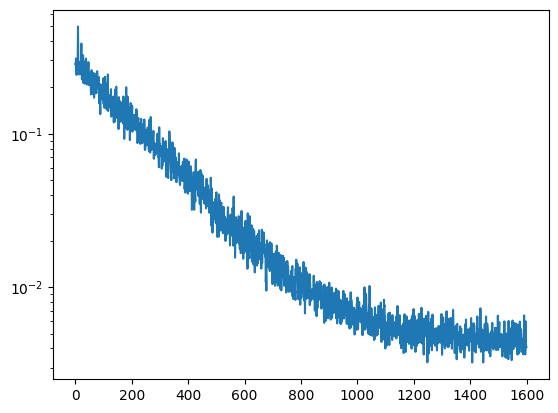

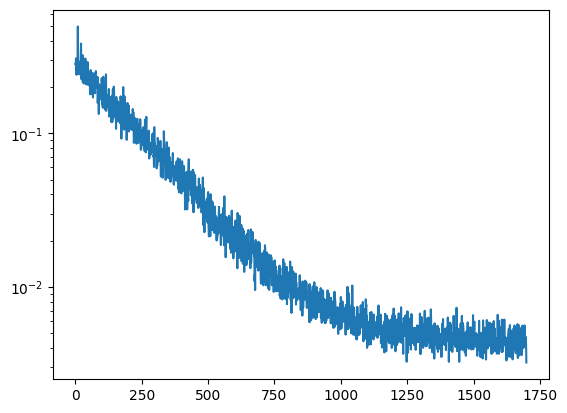

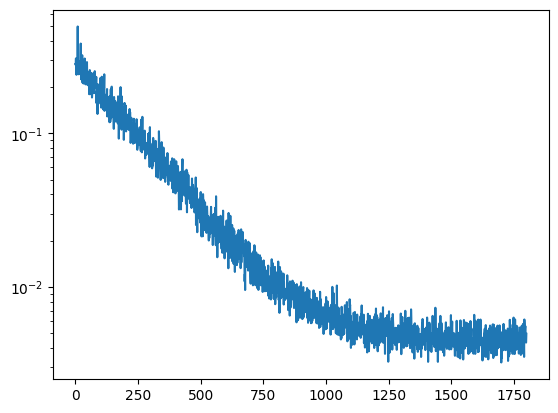

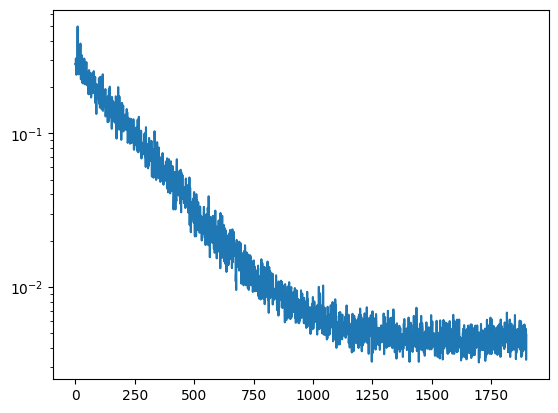

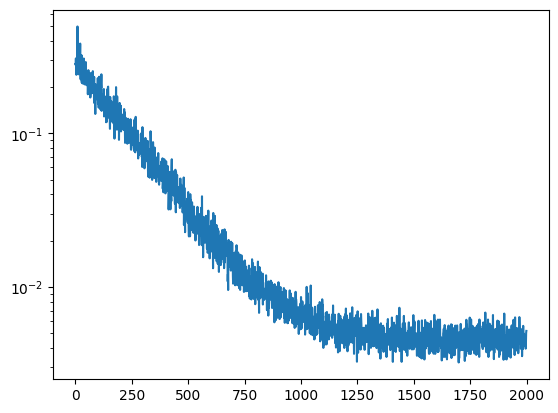

In [31]:
optimizer = torch.optim.Adam(layer.parameters(), lr=1e-2)

n_training = 2000
check_every = 1
plot_every = 100

loss = np.zeros(n_training)


for t in range(1, n_training+1):
    vec = torch.randn_like(psi_coarse)
    
    Dvec = w_coarse(vec)
    
    norm = l2norm(Dvec)
    Dvec = Dvec / norm
    vec = vec / norm
    
    sDvec = torch.stack([Dvec])
    score = complex_mse_loss(layer.forward(sDvec), torch.stack([vec]))
    print(f"T [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|N/A>", end="\r")
    loss[t-1] = score.item()
    optimizer.zero_grad()
    score.backward()
    optimizer.step()
    

    print(f"  [{t:5d}|{t / n_training * 100:6.2f}%] <{score.item():.3e}|N/A>", end="\r")
    if t % plot_every == 0:
        plt.plot(loss[0:t])
        plt.yscale("log")
        plt.show()

print()

In [32]:
torch.save(list(layer.parameters()), "coarse.pt")


In [33]:
torch.save([block_size, ui_blocked, n_basis, L_coarse], "mg_setup.pt")